<a href="https://colab.research.google.com/github/moiz200125/FileSystem/blob/main/ANN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving dataset.zip to dataset.zip


In [2]:
import zipfile
import os

with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")


In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [5]:
def load_data(data_dir, target_size=(128, 128)):
    classes = sorted(os.listdir(data_dir))
    images = []
    labels = []

    for label, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                images.append(img)
                labels.append(label)

    images = np.array(images, dtype=np.float32) / 255.0  # Normalize
    labels = np.array(labels)
    return images, labels, classes

# Load dataset
data_dir = 'dataset/dataset/train'
images, labels, classes = load_data(data_dir)

# Split into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# One-hot encoding
num_classes = len(classes)
train_labels_onehot = np.eye(num_classes)[train_labels]
val_labels_onehot = np.eye(num_classes)[val_labels]


In [6]:
class ANN:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_output = np.zeros((1, output_size))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def forward(self, x):
        self.hidden_layer = self.relu(np.dot(x, self.weights_input_hidden) + self.bias_hidden)
        self.output_layer = self.softmax(np.dot(self.hidden_layer, self.weights_hidden_output) + self.bias_output)
        return self.output_layer

    def backward(self, x, y, learning_rate):
        batch_size = x.shape[0]

        # Output layer gradient
        output_error = self.output_layer - y
        grad_weights_hidden_output = np.dot(self.hidden_layer.T, output_error) / batch_size
        grad_bias_output = np.sum(output_error, axis=0, keepdims=True) / batch_size

        # Hidden layer gradient
        hidden_error = np.dot(output_error, self.weights_hidden_output.T) * self.relu_derivative(self.hidden_layer)
        grad_weights_input_hidden = np.dot(x.T, hidden_error) / batch_size
        grad_bias_hidden = np.sum(hidden_error, axis=0, keepdims=True) / batch_size

        # Update weights and biases
        self.weights_hidden_output -= learning_rate * grad_weights_hidden_output
        self.bias_output -= learning_rate * grad_bias_output
        self.weights_input_hidden -= learning_rate * grad_weights_input_hidden
        self.bias_hidden -= learning_rate * grad_bias_hidden


In [7]:
# Initialize the model
input_size = train_images.shape[1] * train_images.shape[2] * train_images.shape[3]
hidden_size = 64
output_size = num_classes
learning_rate = 0.01
epochs = 50

model = ANN(input_size, hidden_size, output_size)

# Flatten images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
val_images_flat = val_images.reshape(val_images.shape[0], -1)

# Training loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Forward pass
    predictions = model.forward(train_images_flat)
    train_loss = -np.mean(np.sum(train_labels_onehot * np.log(predictions + 1e-8), axis=1))
    train_losses.append(train_loss)

    # Backward pass
    model.backward(train_images_flat, train_labels_onehot, learning_rate)

    # Validation loss
    val_predictions = model.forward(val_images_flat)
    val_loss = -np.mean(np.sum(val_labels_onehot * np.log(val_predictions + 1e-8), axis=1))
    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


Epoch 10/50, Train Loss: 1.5187, Validation Loss: 1.5661
Epoch 20/50, Train Loss: 1.3709, Validation Loss: 1.4454
Epoch 30/50, Train Loss: 1.1343, Validation Loss: 1.2577
Epoch 40/50, Train Loss: 0.9125, Validation Loss: 1.0870
Epoch 50/50, Train Loss: 0.7737, Validation Loss: 0.9639


In [8]:
np.savez('weather_model_weights.npz',
         weights_input_hidden=model.weights_input_hidden,
         bias_hidden=model.bias_hidden,
         weights_hidden_output=model.weights_hidden_output,
         bias_output=model.bias_output)


In [19]:
def predict_weather(image_path, model, classes):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img_flat = img.flatten().astype(np.float32) / 255.0
    img_flat = img_flat.reshape(1, -1)

    predictions = model.forward(img_flat)
    predicted_class = np.argmax(predictions)
    print(f"Predicted Weather: {classes[predicted_class]}")

# Example prediction
predict_weather('Test_Image11.jpg', model, classes)


Predicted Weather: snowy


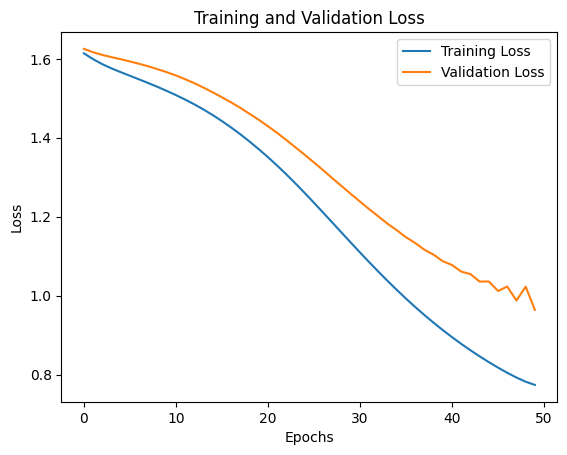

In [10]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()
